In [5]:
%matplotlib inline
#%load_ext autoreload
#%autoreload 2  
%reload_ext autoreload
import matplotlib.pyplot as plt
import numpy as np
import math
from numpy.random import randn
import plots

In [6]:

class MouseSimulation(object):   
    def __init__(self, x0=0, velocity=1,
                 measurement_var=0.0, 
                 process_var=0.0):
        """ 
        x0 :initial position
        velocity: (+=right, -=left)
        measurement_var: variance in measurement m^2
        process_var: variance in process (m/s)^2
        """
        self.x = x0
        self.velocity = velocity
        self.meas_noise = math.sqrt(measurement_var)
        self.process_noise = math.sqrt(process_var)

    def move(self, dt=1.0):
        """Compute new position of the mouse in dt seconds."""
        dx = self.velocity + randn()*self.process_noise
        self.x += dx * dt
        
    def sense_position(self):
        # simulate measuring the position with noise
        measurement = self.x + randn()*self.meas_noise
        return measurement
    
    def move_and_sense(self):
        self.move()
        return self.sense_position()

1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0


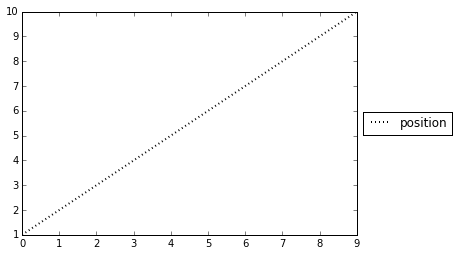

In [7]:
mouse = MouseSimulation(measurement_var=0.0)
xs = np.zeros(10)
for i in range(10):
    mouse.move()
    xs[i] = mouse.sense_position()
    print("%.1f" % xs[i]),
plots.plot_track(xs, label='position')
plots.show_legend();

/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


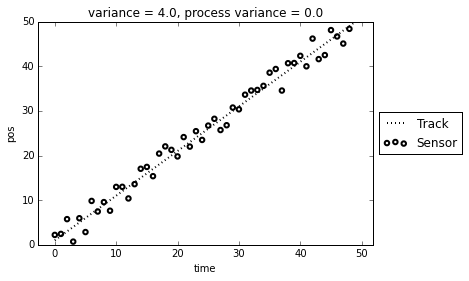

In [8]:
def test_sensor(measurement_var, process_var=0.0):
    mouse = MouseSimulation(0., 1., measurement_var, process_var)
    N = 50
    xs = np.zeros(N)
    for i in range(N):
        mouse.move()
        xs[i] = mouse.sense_position()

    plots.tracking_plot(xs, measurement_var, process_var)
    
test_sensor(measurement_var=4.0)

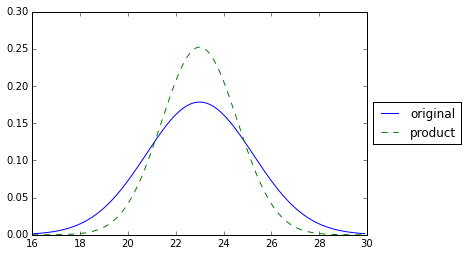

In [10]:
import filterpy.stats as stats

def multiply_1d_gaussians(mu1, var1, mu2, var2):
    if var1 == 0.0:
        var1=1.e-80      
    if var2 == 0:
        var2 = 1e-80
        
    mean = (var1*mu2 + var2*mu1) / (var1+var2)
    variance = 1.0 / (1.0/var1 + 1.0/var2)
    return (mean, variance)

xs = np.arange(16, 30, 0.1)

mean1, var1 = 23.0, 5.0
mean, var = multiply_1d_gaussians(mean1, var1, mean1, var1)

ys = [stats.gaussian(x, mean1, var1) for x in xs]
plt.plot(xs, ys, label='original')

ys = [stats.gaussian(x, mean, var) for x in xs]
plt.plot(xs, ys, label='product', ls='--')
plots.show_legend()

In [11]:
from numpy.random import randn

class Gaussian:
    def __init__(self,mu,sigma_2):
        self.mu = mu
        self.sigma_2 = sigma_2
    
    def add(self, other):
        return Gaussian(self.mu + other.mu, self.sigma_2 + other.sigma_2)
    
    def multiply(self,other):
        if self.sigma_2 == 0.0:
            self.sigma_2 = 1.e-80      
        if other.sigma_2 == 0:
            other.sigma_2 = 1e-80
        mu = (self.sigma_2*other.mu + other.sigma_2*self.mu) / (self.sigma_2+other.sigma_2)
        sigma_2 = 1.0 / (1.0/self.sigma_2 + 1.0/other.sigma_2)
        return Gaussian(mu, sigma_2)
    
    def sample(self):
        return randn()*np.sqrt(self.sigma_2) + self.mu
        

class Kalman_Filter_1d:
    def __init__(self, initial_loc, process_velocity, process_variance, measurement_variance, dt = 1.0):
        """
        initial_loc_est: A gaussian with the estimate of location
        process_velocity: The velocity of the process
        process_variance: 
        """
        
        self.steps = 0.
        self.dt = dt
        self.process_velocity = process_velocity
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        
        self.process_pos = initial_loc
        self.process_history = []
        
        self.z = initial_loc
        self.z_history = []
        
        self.filter_pos = Gaussian(initial_loc, process_variance)
        self.filter_history = []
        
        self.predicted_pos = Gaussian(initial_loc, 400.0)
        self.predicted_pos_history = []
        
    
    def move(self):
        dx = self.process_velocity + randn()*self.process_variance
        movement = dx * self.dt
        self.process_history.append(self.process_pos)
        self.process_pos += movement
    
    def sense(self):
        self.z_history.append(self.z)
        self.z = self.process_pos + randn()*self.measurement_variance
        
    def move_and_sense(self):
        self.move()
        self.sense()

    def predict(self):
        movement_est = Gaussian(self.process_velocity, self.process_variance)
        self.predicted_pos_history.append(self.predicted_pos)
        self.predicted_pos = self.filter_pos.add(movement_est)
    
    def update(self):
        measurement = Gaussian(self.z,self.measurement_variance)
        self.filter_history.append(self.filter_pos)
        self.filter_pos = self.predicted_pos.multiply(measurement)
    
    def step(self):
        self.move_and_sense()
        self.predict()
        self.update()
        self.steps += 1
    
    def run(self,n):
        for s in range(n):
            self.step()
            self.print_current()

    def print_current(self):
        print("")
        print("step: %f" % self.steps)
        print("process_pos: %f" % self.process_pos)
        print("measurement_pos: %f" % self.z) 
        print("predicted_pos: %f, prediction_var: %f" % (self.predicted_pos.mu, self.predicted_pos.sigma_2))
        print("filter_pos: %f, filter_var: %f" % (self.filter_pos.mu, self.filter_pos.sigma_2))
        

In [12]:
np.random.seed(13)
pos = 0.
process_velocity = 1.

# variance in process model and the RFID sensor
process_var = 1.
sensor_var = 2.

kalman_filter = Kalman_Filter_1d(pos, process_velocity, process_var, sensor_var)
kalman_filter.run(10)



step: 1.000000
process_pos: 0.287609
measurement_pos: 1.795142
predicted_pos: 1.000000, prediction_var: 2.000000
filter_pos: 1.397571, filter_var: 1.000000

step: 2.000000
process_pos: 1.243106
measurement_pos: 2.146731
predicted_pos: 2.397571, prediction_var: 2.000000
filter_pos: 2.272151, filter_var: 1.000000

step: 3.000000
process_pos: 3.588208
measurement_pos: 4.652884
predicted_pos: 3.272151, prediction_var: 2.000000
filter_pos: 3.962517, filter_var: 1.000000

step: 4.000000
process_pos: 5.938396
measurement_pos: 7.660819
predicted_pos: 4.962517, prediction_var: 2.000000
filter_pos: 6.311668, filter_var: 1.000000

step: 5.000000
process_pos: 8.417082
measurement_pos: 6.326327
predicted_pos: 7.311668, prediction_var: 2.000000
filter_pos: 6.818998, filter_var: 1.000000

step: 6.000000
process_pos: 8.628093
measurement_pos: 6.104881
predicted_pos: 7.818998, prediction_var: 2.000000
filter_pos: 6.961939, filter_var: 1.000000

step: 7.000000
process_pos: 10.190939
measurement_pos: 9.